# Analysis


In [1]:
import os, glob
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read input data

In [2]:
def script_read_multiruns(in_parent_dir):
    IN_PARENT_DIR = in_parent_dir
    Prog_File_wc = '*/train_incremental.log'  # or progress.csv TODO figure out
    Config_File_wc = '*/.hydra/config.yaml'
    
    PD_DF_SEP = '\|'
    
    
    def get_progress_file_dict_key(path_str):
        """Helper method to get dict key for both the progress files
        and the config files"""
        return path_str.split('/')[-2]
    
    def get_config_file_dict_key(path_str):
        return path_str.split('/')[-3]
        
    mr_dict = {}
    
    prog_file_path_list = glob.glob(os.path.join(IN_PARENT_DIR, Prog_File_wc))
    for path in prog_file_path_list:
        d_k = get_progress_file_dict_key(path)
        mr_dict[d_k] = {
            'df': pd.read_csv(path, sep=PD_DF_SEP)
        }
    
    for path in glob.glob(os.path.join(IN_PARENT_DIR, Config_File_wc)):
        d_k = get_config_file_dict_key(path)
        mr_dict[d_k]['config'] = yaml.load(open(path))
    
    return mr_dict
        

ksf_DataDict = script_read_multiruns(
    '/Users/anthony/Playground/tensorboard_logs/sr_return/2021-01-24/partial_seaquest'
)
tdlamb_DataDict = script_read_multiruns(
    '/Users/anthony/Playground/tensorboard_logs/sr_return/2021-01-22/21-59-18'
)

len(ksf_DataDict)

/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


6

#### Get all attributes into columns and concate all runs

In [3]:
import collections

def construct_data_df(runs_dict):    
    def recursive_helper(configDict, curStr='', headerDict={}):
        """Helper to extract all the nested attributes into a
        single attribute dict"""
        # Base case: no child dictionaries
        if not isinstance(configDict, collections.Mapping):
            headerDict[curStr] = str(configDict)
            return None
        
        # Recursion
        for k in configDict:
            if len(curStr) == 0:
                childStr = k
            else:
                childStr = f'{curStr}.{k}'
            recursive_helper(configDict[k], childStr, headerDict)
        return None
    
    # ==
    # Add configs to dataframes and concat
    all_df_list = []
    
    for run_k in runs_dict:
        cur_run_dict = runs_dict[run_k]
        
        # Extract header
        config_dict = {}
        recursive_helper(cur_run_dict['config'], 
                         curStr='', 
                         headerDict=config_dict)
        
        
        # Add to dataframe
        cur_df = cur_run_dict['df'].copy(deep=True)
        for header_k in config_dict:
            col_val = config_dict[header_k]
            cur_df[header_k] = [col_val] * len(cur_df)
            
        
        all_df_list.append(cur_df)
        
    # ==
    # Concat and output
    all_concat_df = pd.concat(all_df_list)
    all_concat_df = all_concat_df.reset_index()
    
    return all_concat_df


tdlamb_Data_df = construct_data_df(tdlamb_DataDict)
kdf_Data_df = construct_data_df(ksf_DataDict)

print(len(tdlamb_Data_df))
print(len(kdf_Data_df))
kdf_Data_df[0:3]

1590
4143


/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  


,index,"[2021-01-24 14:13:30,383][Experiment][INFO] - episode_count",total_steps,episode_return,exp_average_return,value_loss,reward_loss,sf_loss,lsf_v_v_diff,et_loss,...,algo.kwargs.min_denom,algo.kwargs.sf_lambda,model.cls_string,model.kwargs.fc_sizes,model.kwargs.sf_hidden_sizes,"[2021-01-24 23:43:26,609][Experiment][INFO] - episode_count","[2021-01-23 14:55:13,922][Experiment][INFO] - episode_count","[2021-01-26 05:01:04,171][Experiment][INFO] - episode_count","[2021-01-25 19:41:56,404][Experiment][INFO] - episode_count","[2021-01-25 10:12:53,587][Experiment][INFO] - episode_count"
0,0,"[2021-01-24 14:13:40,688][Experiment][INFO] - 50",1550,0.02,0.009703,0.001402,0.000796,0.001482,0.001831,None,...,0.0001,0.3,LSF_ACNetwork,128,None,NaN,NaN,NaN,NaN,NaN
1,1,"[2021-01-24 14:13:52,351][Experiment][INFO] - 100",3263,0.06,0.030157,0.001791,0.000572,0.000001,0.001424,None,...,0.0001,0.3,LSF_ACNetwork,128,None,NaN,NaN,NaN,NaN,NaN
2,2,"[2021-01-24 14:14:12,518][Experiment][INFO] - 150",6319,0.42,0.186028,0.010838,0.002587,0.000002,0.003450,None,...,0.0001,0.3,LSF_ACNetwork,128,None,NaN,NaN,NaN,NaN,NaN


In [4]:
print(kdf_Data_df.columns.values.tolist())

['index', '[2021-01-24 14:13:30,383][Experiment][INFO] - episode_count', 'total_steps', 'episode_return', 'exp_average_return', 'value_loss', 'reward_loss', 'sf_loss', 'lsf_v_v_diff', 'et_loss', 'training.seed', 'runner.n_steps', 'runner.kwargs.log_interval_episodes', 'runner.kwargs.log_dir_path', 'runner.kwargs.store_checkpoint', 'runner.kwargs.checkpoint_type', 'runner.kwargs.checkpoint_freq', 'runner.kwargs.checkpoint_dir_path', 'runner.kwargs.load_model_path', 'env.kwargs.env_name', 'algo.cls_string', 'algo.kwargs.discount_gamma', 'algo.kwargs.lr_alpha', 'algo.kwargs.trace_lambda', 'algo.kwargs.entropy_beta', 'algo.kwargs.grad_rms_gamma', 'algo.kwargs.grad_rms_eps', 'algo.kwargs.min_denom', 'algo.kwargs.sf_lambda', 'model.cls_string', 'model.kwargs.fc_sizes', 'model.kwargs.sf_hidden_sizes', '[2021-01-24 23:43:26,609][Experiment][INFO] - episode_count', '[2021-01-23 14:55:13,922][Experiment][INFO] - episode_count', '[2021-01-26 05:01:04,171][Experiment][INFO] - episode_count', '[202

## Explatory Plots

In [5]:
set(kdf_Data_df['algo.cls_string'].values)

{'LSF_ACLambda'}

In [6]:
set(kdf_Data_df['algo.kwargs.trace_lambda'].values)

{'0.0'}

In [7]:
set(kdf_Data_df['algo.kwargs.sf_lambda'].values)

{'0.3', '0.8'}

In [8]:
set(kdf_Data_df['training.seed'].values)

{'12', '15', '3', '6', '9'}

In [9]:
set(tdlamb_Data_df['algo.cls_string'].values)

{'ACLambda'}

In [10]:
set(tdlamb_Data_df['algo.kwargs.trace_lambda'].values)

{'0.0'}

In [11]:
set(tdlamb_Data_df['training.seed'].values)

{'2', '4'}

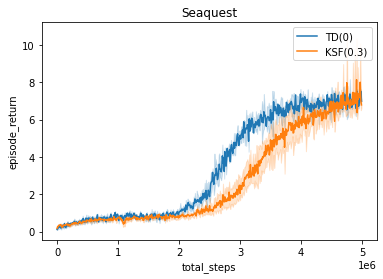

In [15]:
def round_2_int(value, nearest=10):
    try:
        rounded = int(value / nearest) * nearest
    except ValueError:
        rounded = np.nan
    return rounded

def simple_lineplot(x, y, data, sns_kwargs={},
                    round_x=None, round_y=None,
                    filters=None):    
    df = data.copy(deep=True)
    # In case non numeric
    df[x] = pd.to_numeric(df[x], errors='coerce')
    df[y] = pd.to_numeric(df[y], errors='coerce')
    # if roudning
    if round_x is not None:
        df[x] = [round_2_int(v, round_x) for v in df[x].values]
    if round_y is not None:
        df[y] = [round_2_int(v, round_y) for v in df[y].values]

    
    if filters is not None:
        for f_k in filters:
            df = df[df[f_k] == filters[f_k]]
    
    sns.lineplot(x=x, y=y,
                 data=df, **sns_kwargs)
    
    
simple_lineplot(
    x='total_steps', y='episode_return', 
    round_x=1e4,
    data=tdlamb_Data_df,
    sns_kwargs={'ci': 95, 'n_boot': 100},
    filters={}
)

simple_lineplot(
    x='total_steps', y='episode_return', 
    round_x=1e4,
    data=kdf_Data_df,
    sns_kwargs={'ci': 95, 'n_boot': 100},
    filters={'algo.kwargs.sf_lambda': '0.3'}
)
plt.legend(['TD(0)', 'KSF(0.3)'])
plt.title('Seaquest')
plt.show()

In [ ]:
def script_plt_multi_sf_hidden_sizes(df):
    plt_hue = 'algo.kwargs.sf_lambda'
    
    df = df.copy(deep=True)
    df[plt_hue] = pd.to_numeric(df[plt_hue], errors='coerce')
    
    
    
    plt.figure(figsize=(14,4))
    
    n_hues = len(set(df[plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    #c_palette = None
    
    plt.subplot(1,2,1)
    simple_lineplot(
        x='total_steps', y='episode_return', 
        round_x=5e3,
        data=df,
        sns_kwargs={'hue': 'algo.kwargs.sf_lambda', 
                    'palette': c_palette,
                    'ci': 'sd', 'n_boot': 10},
        filters={'model.kwargs.sf_hidden_sizes':'[256]'}
    )
    plt.title('SF hidden sizes: [256]')
    
    plt.subplot(1,2,2)
    simple_lineplot(
        x='total_steps', y='episode_return', 
        round_x=5e3,
        data=df,
        sns_kwargs={'hue': 'algo.kwargs.sf_lambda', 
                    'palette': c_palette,
                    'ci': 'sd', 'n_boot': 10},
        filters={'model.kwargs.sf_hidden_sizes':'[256, 256]'}
    )
    plt.title('SF hidden sizes: [256, 256]')

script_plt_multi_sf_hidden_sizes(Data_df)